In [1]:


from IPython.display import Image
import openmc
import openmc.lib

# ensure one of the two mesh libraries is enabled
assert(openmc.lib._dagmc_enabled() or openmc.lib._libmesh_enabled())



In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (30,10)

import urllib.request

pin_mesh_moab_url = 'https://tinyurl.com/u9ce9d7' # MOAB file - 22 MB
pin_mesh_libmesh_url = 'https://tinyurl.com/yysgs3tr' # Exodus file - 9.7 MB

def download(url, filename='dagmc.h5m'):
    """
    Helper function for retrieving dagmc models
    """
    u = urllib.request.urlopen(url)
    
    if u.status != 200:
        raise RuntimeError("Failed to download file.")
    
    # save file as dagmc.h5m
    with open(filename, 'wb') as f:
        f.write(u.read())

In [3]:
model = openmc.examples.pwr_assembly()

In [4]:


min_z = openmc.ZPlane(z0=-10.0)
max_z = openmc.ZPlane(z0=10.0)

z_region = +min_z & -max_z

cells = model.geometry.get_all_cells()
for cell in cells.values():
    cell.region &= z_region

In [5]:


surfaces = model.geometry.get_all_surfaces()
# modify the boundary condition of the
# planar surfaces bounding the assembly
for surface in surfaces.values():
    if isinstance(surface, openmc.Plane):
        surface.boundary_type = 'vacuum'



<Axes: xlabel='x [cm]', ylabel='z [cm]'>

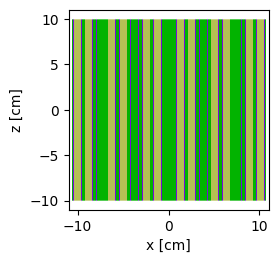

In [6]:


root_univ = model.geometry.root_universe

# axial image
root_univ.plot(width=(22.0, 22.0),
               pixels=(200, 300),
               basis='xz',
               color_by='material',
               seed=1)



<Axes: xlabel='x [cm]', ylabel='y [cm]'>

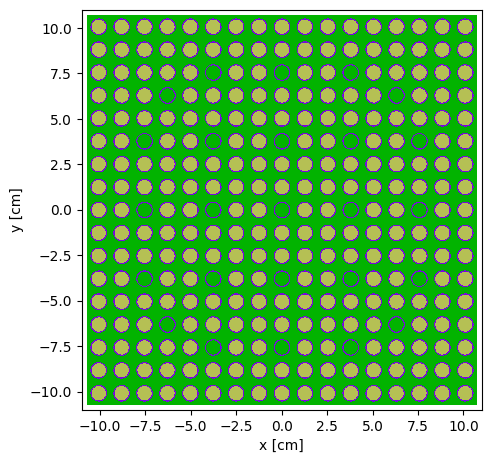

In [7]:


# radial image
root_univ.plot(width=(22.0, 22.0),
               pixels=(400, 400),
               basis='xy',
               color_by='material',
               seed=1)



In [8]:
model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/home/dresden/tutorial_trial/statepoint.10.h5')

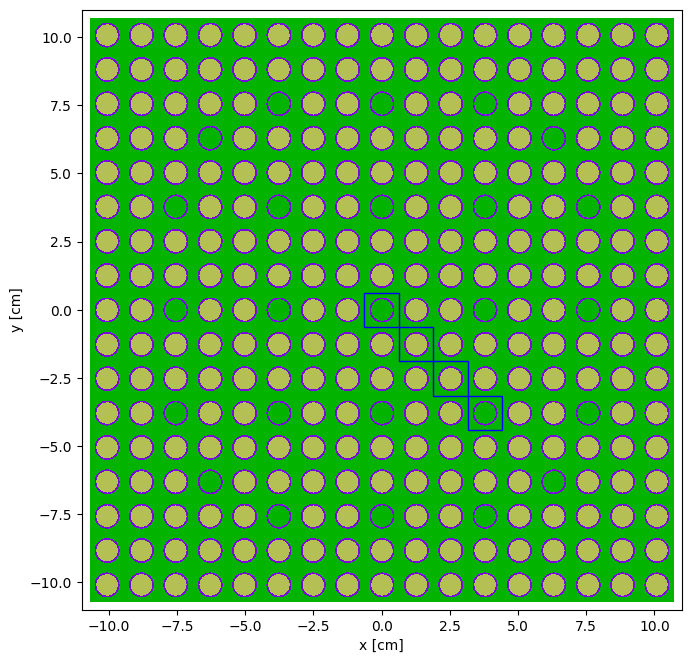

In [10]:


from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt

pitch = 1.26 # cm

img = root_univ.plot(width=(22.0, 22.0),
                           pixels=(600, 600),
                           basis='xy',
                           color_by='material',
                           seed=1)

# highlight channels
for i in range(0, 4):
    corner = (i * pitch - pitch / 2.0, -i * pitch - pitch / 2.0)
    rect = Rectangle(corner,
                     pitch,
                     pitch,
                     edgecolor='blue',
                     fill=False)
    img.axes.add_artist(rect)



In [11]:
mesh_library = 'moab' # change to 'libmesh' to use libMesh instead

if mesh_library == 'moab':
    assert(openmc.lib._dagmc_enabled())
    mesh_file = 'pins1-4.h5m'
    mesh_url = pin_mesh_moab_url
elif mesh_library == 'libmesh':
    assert(openmc.lib._libmesh_enabled())
    mesh_file = 'pins1-4.e'
    mesh_url = pin_mesh_libmesh_url
    
# download the file and create the UnstructuredMesh object
download(mesh_url, mesh_file)
umesh = openmc.UnstructuredMesh(mesh_file, library=mesh_library)


In [12]:
mesh_filter = openmc.MeshFilter(umesh)

In [13]:


tally = openmc.Tally()
tally.filters = [mesh_filter]
tally.scores = ['heating', 'flux']
# Only collision estimators are supported for 
if umesh.library == 'libmesh':
    tally.estimator = 'collision'
model.tallies = [tally]



In [14]:


model.settings.particles = 10_000
model.settings.inactive = 20
model.settings.batches = 100
sp_file = model.run(output=True)



                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [9]:
import openmc
with openmc.StatePoint("statepoint.100.h5") as sp:
    sp_tally = sp.get_tally(id=1)
    sp_umesh = sp_tally.find_filter(openmc.MeshFilter).mesh
    
# data coming from the tally object will have three dimensions.
# make sure to shape the results to match the mesh elements
flux_mean = sp_tally.get_values(scores=['flux'], value='mean').reshape(sp_umesh.dimension)
flux_std_dev = sp_tally.get_values(scores=['flux'], value='std_dev').reshape(sp_umesh.dimension)
heating_mean = sp_tally.get_values(scores=['heating'], value='mean').reshape(sp_umesh.dimension)
heating_std_dev = sp_tally.get_values(scores=['heating'], value='std_dev').reshape(sp_umesh.dimension)

vtk_data_dict = {'flux_mean': flux_mean,
                 'flux_std_dev': flux_std_dev,
                 'heating_mean': heating_mean,
                 'heating_std_dev': heating_std_dev}
sp_umesh.write_data_to_vtk('pin_data.vtk', datasets=vtk_data_dict)

In [14]:
import numpy as np
energies = np.logspace(np.log10(1e-5), np.log10(20.0e6), 680289)
e_filter = openmc.EnergyFilter(energies)
tallies = openmc.Tallies()
# Create tally with energy filter
tally = openmc.Tally()
tally.filters = [e_filter]
tally.scores = ['flux']
# Create energy filter using SHEM-361 group structure
energies_shem = openmc.mgxs.GROUP_STRUCTURES['SHEM-361']
shem_filter = openmc.EnergyFilter(openmc.mgxs.GROUP_STRUCTURES['SHEM-361'])

tally_shem = openmc.Tally()
tally_shem.filters = [shem_filter]
tally_shem.scores = ['flux']
tallies.append(tally)
tallies.export_to_xml()

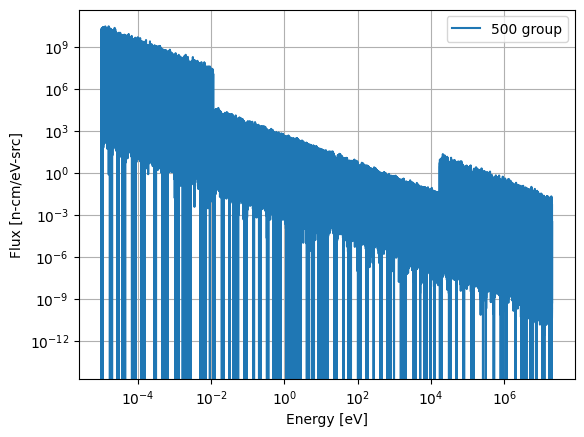

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.step(energies[:-1], flux500_mean/np.diff(energies), where='post', label='500 group')
#ax.step(energies_shem[:-1], flux_shem_mean/np.diff(energies_shem), where='post', label='SHEM-361')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Flux [n-cm/eV-src]')
ax.grid()
ax.legend()

In [4]:
with openmc.StatePoint("statepoint.100.h5") as sp:
    t = sp.tallies[1]
    flux500_mean = t.mean.ravel()
    flux500_unc = t.std_dev.ravel()
    
    t_shem = sp.tallies[1]
    flux_shem_mean = t_shem.mean.ravel()
    flux_shem_unc = t_shem.std_dev.ravel()

print(flux_shem_e